# Flare Energy Determination

- [Method and Example](#Method-and-Example)
- [Flares recovered from injected light curves](#Flares-recovered-from-injected-light-curves)
- [Flares detected on the original light curves](#Flares-detected-on-the-original-light-curves)
- [Additional Cross-Matching](#Additional-Cross-Matching)

In [6]:
import sys
import numpy as np

from astropy.table import Table, Column, vstack
from astropy.time import Time

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

sys.path.append('../src')

import arhap

import findflares
import energy

## Adjusting tables

We need to add distance and extinction values to the light curve info tables.

In [2]:
lc_info_table = Table.read("../data_tables/kepler_longcad_info.ecsv", format="ascii.ecsv")
galex_flare_stats  = Table.read("../data_tables/galex_flare_stats.ecsv", format="ascii.ecsv")

In [25]:
# Column names are proscribed by the energy finding functions and come from the original sources
# Distances are from Bailer-Jones et. al (2018)
# Extinction is from dustmaps (https://dustmaps.readthedocs.io)

lc_info_table.add_column(Column(name="r_est", dtype=float, length=len(lc_info_table)))
lc_info_table.add_column(Column(name="r_hi", dtype=float, length=len(lc_info_table)))
lc_info_table.add_column(Column(name="r_lo", dtype=float, length=len(lc_info_table)))
lc_info_table.add_column(Column(name="E(B-V)", dtype=float, length=len(lc_info_table)))

for row in lc_info_table:
    row["r_est"] = galex_flare_stats[galex_flare_stats["KID"] == row["KID"]][0]["Dist"]
    row["r_lo"] = galex_flare_stats[galex_flare_stats["KID"] == row["KID"]][0]["e_Dist"]
    row["r_hi"] = galex_flare_stats[galex_flare_stats["KID"] == row["KID"]][0]["E_Dist"]
    row["E(B-V)"] = galex_flare_stats[galex_flare_stats["KID"] == row["KID"]][0]["E(B-V)"]
    
lc_info_table.write("../data_tables/kepler_longcad_info.ecsv", format="ascii.ecsv", overwrite=True)

## Method and Example

In [4]:
recovered_injflare_table = Table.read("../data_tables/recovered_injected_flares_longcad.ecsv",format="ascii.ecsv")

In [4]:
kep_obj = lc_info_table[55]
lc_table = Table.read(kep_obj['injected_path'], format="ascii.ecsv")
flare_table = recovered_injflare_table[recovered_injflare_table["kid"] == kep_obj["KID"]]

print(f"Number of detected flares: {len(flare_table)}")

Number of detected flares: 10


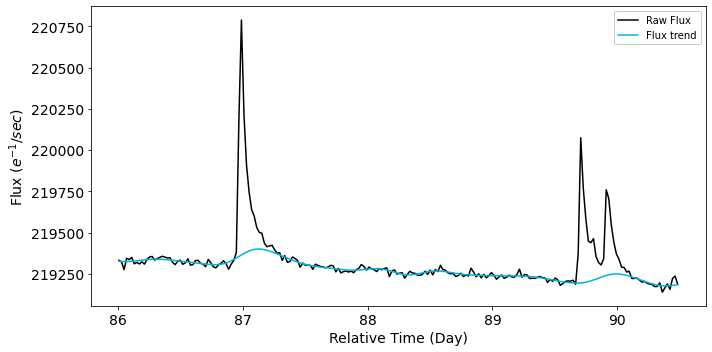

In [5]:
f, ax = plt.subplots(figsize=(10, 5))
ax.tick_params(axis='both', which='major', labelsize=14)

sttime = lc_table['time'][0].jd
min_ind = arhap.find_nearest(lc_table['time'].jd, sttime+86)
max_ind = arhap.find_nearest(lc_table['time'].jd, sttime+90.5)

ax.plot(lc_table['time'].jd[min_ind:max_ind] - sttime, lc_table['flux'][min_ind:max_ind], 
        c='black', label="Raw Flux")
ax.plot(lc_table['time'].jd[min_ind:max_ind] - sttime, lc_table['flux_model'][min_ind:max_ind], 
        c="#00b2dd", label="Flux trend")
       
ax.set_xlabel("Relative Time (Day)", fontsize=14)
ax.set_ylabel("Flux ($e^{-1}/sec$)", fontsize=14)
ax.legend(framealpha=1)

plt.tight_layout()
plt.show()

#### Calculating the quiescent flux

In the plot above you can see that the model flux detrends out some of the flare flux, so instead of using the model flux as the quiescent flux, we will calculate a local quiescent flux by fitting a line between a number of quiescent flux points to either side of the flare.

We chose to use 10 points on either side, with a 5 point buffer between the flare and the presumed quiescent flux, to account for cases where the calculated flare edges are incorrect.

In [7]:
flare_table.add_column(Column(name="qui_m",dtype=float, length=len(flare_table)))
flare_table.add_column(Column(name="qui_b",dtype=float, length=len(flare_table)))
flare_table.add_column(Column(name="qui_std",dtype=float, length=len(flare_table)))

In [8]:
flare_table.sort("start_ind")

# combine_intervals, takes into account some flares being close enough together 
# they should be combined for quiescent flux purposes
qui_inds = arhap.combine_intervals(flare_table, "start_ind", "end_ind", 15) 

flare_table["qui_start"] = qui_inds["start_ind"]
flare_table["qui_end"] = qui_inds["end_ind"]

In [9]:
for flare in flare_table:
    flare["qui_m","qui_b","qui_std"] = energy.calc_qui_flux_parms(lc_table, flare["qui_start","qui_end"], 2, 5)

In [10]:
flare_table.remove_columns(("qui_start", "qui_end"))

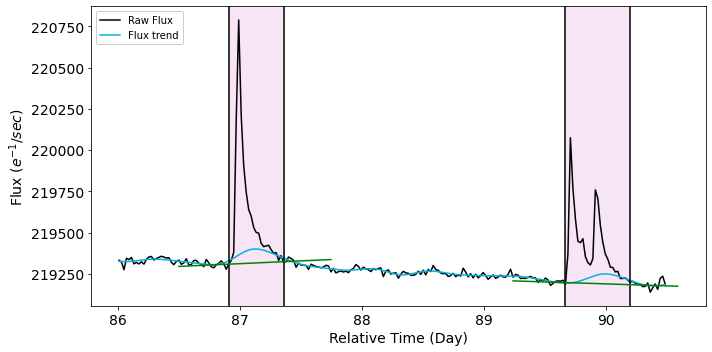

In [10]:
f, ax = plt.subplots(figsize=(10, 5))
ax.tick_params(axis='both', which='major', labelsize=14)

sttime = lc_table['time'][0].jd
min_ind = arhap.find_nearest(lc_table['time'].jd, sttime+86)
max_ind = arhap.find_nearest(lc_table['time'].jd, sttime+90.5)

ax.plot(lc_table['time'].jd[min_ind:max_ind] - sttime, lc_table['flux'][min_ind:max_ind], 
        c='black', label="Raw Flux")
ax.plot(lc_table['time'].jd[min_ind:max_ind] - sttime, lc_table['flux_model'][min_ind:max_ind], 
        c="#00b2dd", label="Flux trend")
       
for flare in flare_table:
    if (flare['start_ind'] > max_ind) or (flare['end_ind'] < min_ind):
        continue
    ax.axvspan(flare['start_time'].jd - sttime, flare['end_time'].jd - sttime, alpha=0.1, color='#b400ac')
    ax.axvline(flare['start_time'].jd - sttime, color='black')
    ax.axvline(flare['end_time'].jd - sttime, color='black')

    qui_times = lc_table['time'].jd[flare['start_ind']-20:flare['end_ind']+20]
    ax.plot(qui_times - sttime, energy.line_func(qui_times, flare['qui_m'], flare['qui_b']), color="green")
    
ax.set_xlabel("Relative Time (Day)", fontsize=14)
ax.set_ylabel("Flux ($e^{-1}/sec$)", fontsize=14)
ax.legend(framealpha=1)

plt.tight_layout()
plt.show()

#### Adjusting the flare edges

Looking closely at the plots of various flares, we found that some of the flares were forshortened due to the way that the flux model detrends out parts of the flare (This can be seen ever so slightly in the left flare above, although if is much more extreme in other flares). So we want to ajust the flare bounds with respect to the new quiescent flux line. 

We do this by runing the flares through the `find_flare_edges` function again, but this time with the improved quiescent flux line.

In [11]:
for flare in flare_table:
    qui_flux_calc = energy.line_func(lc_table['time'].jd, flare['qui_m'], flare['qui_b'])
    flare['start_ind'], flare['end_ind'] = findflares.find_flare_edges(lc_table['flux'], flare['start_ind'], 
                                                                       flare['end_ind'], qui_flux_calc)
    
    flare['start_time'] = lc_table['time'][flare['start_ind']]
    flare['end_time'] =lc_table['time'][flare['end_ind']]

Sometimes this means that what was previously two flares now gets detected as one. So we need to dedupe.

In [12]:
bad_inds = []
for start_ind, end_ind in np.unique(flare_table["start_ind","end_ind"]):
    dupl_locs = np.where((flare_table["start_ind"]==start_ind)&(flare_table["end_ind"]==end_ind))[0]
    duplicates =  flare_table[dupl_locs]
    if len(duplicates) > 1:
        bad_inds.append(*dupl_locs[duplicates["max_flux"] != duplicates["max_flux"].max()])
        
mask = np.ones(len(flare_table),dtype=bool)
mask[bad_inds] = False

flare_table = flare_table[mask]

### Calculating the energy

We calculate the fluence for each flare, and combine that with distance and redenning to get the energy of the flare in the Kepler band.

In [14]:
flare_table.add_column(Column(name="fluence",dtype=float, length=len(flare_table), unit="erg cm-2"))
flare_table.add_column(Column(name="fluence_err",dtype=float, length=len(flare_table), unit="erg cm-2"))
flare_table.add_column(Column(name="E",dtype=float, length=len(flare_table), unit="erg"))
flare_table.add_column(Column(name="E_err_hi",dtype=float, length=len(flare_table), unit="erg"))
flare_table.add_column(Column(name="E_err_lo",dtype=float, length=len(flare_table), unit="erg"))

In [15]:
for flare in flare_table:
    fluence, fluence_err = energy.get_fluence(lc_table, flare, kep_obj)
    E, E_err_hi, E_err_lo = energy.get_kepler_energy(fluence, fluence_err, kep_obj)

    flare["fluence"], flare["fluence_err"] = fluence.value, fluence_err.value
    flare["E"], flare["E_err_hi"], flare["E_err_lo"] = E.value, E_err_hi.value, E_err_lo.value

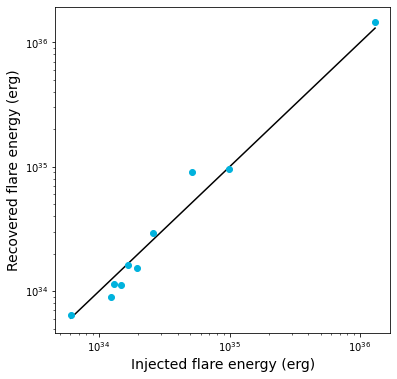

In [16]:
f, ax = plt.subplots(figsize=(6, 6))

minval,maxval = np.min(flare_table['inj_flare_eng']), np.max(flare_table['inj_flare_eng'])
ax.plot([minval,maxval],[minval,maxval], color='black')

ax.plot(flare_table['inj_flare_eng'], flare_table["E"], 'o', color="#00b2dd")

ax.loglog()
ax.set_xlabel("Injected flare energy (erg)", fontsize=14)
ax.set_ylabel("Recovered flare energy (erg)", fontsize=14)

plt.show()

## Flares recovered from injected light curves

**Note:** This step takes a couple of minutes.

In [17]:
lc_info_table = Table.read("../data_tables/kepler_longcad_info.ecsv", format="ascii.ecsv")
recovered_injflare_table = Table.read("../data_tables/recovered_injected_flares_longcad.ecsv",format="ascii.ecsv")

In [ ]:
recovered_injflare_table.add_column(Column(name="qui_m",dtype=float, length=len(recovered_injflare_table)))
recovered_injflare_table.add_column(Column(name="qui_b",dtype=float, length=len(recovered_injflare_table)))
recovered_injflare_table.add_column(Column(name="qui_std",dtype=float, length=len(recovered_injflare_table)))

recovered_injflare_table.add_column(Column(name="fluence",dtype=float, length=len(recovered_injflare_table), unit="erg cm-2"))
recovered_injflare_table.add_column(Column(name="fluence_err",dtype=float, length=len(recovered_injflare_table), unit="erg cm-2"))
recovered_injflare_table.add_column(Column(name="E",dtype=float, length=len(recovered_injflare_table), unit="erg"))
recovered_injflare_table.add_column(Column(name="E_err_hi",dtype=float, length=len(recovered_injflare_table), unit="erg"))
recovered_injflare_table.add_column(Column(name="E_err_lo",dtype=float, length=len(recovered_injflare_table), unit="erg"))

In [ ]:
non_flaring_kids = [] # May want to re-inject flares in these

for kep_obj in lc_info_table:
    
    lc_table = Table.read(kep_obj['injected_path'], format="ascii.ecsv")
    flare_locs = np.where(recovered_injflare_table["kid"] == kep_obj["KID"])[0]
    
    if len(flare_locs) == 0:
        non_flaring_kids.append(kep_obj["KID"])
        continue # no flares, no need to do anything else
        
    # Adjusting the flare start/end indexes used for the quiescent flux calculation
    # There is probably a more clever way to handle this but I can't be bothered to find it
    flare_table = recovered_injflare_table[flare_locs]
    flare_table.sort("start_ind")
    qui_inds = arhap.combine_intervals(flare_table, "start_ind", "end_ind", 7)
    qui_ind_dict = {}
    for i in range(len(qui_inds)):
        qui_ind_dict[flare_table["start_ind"][i]+flare_table["end_ind"][i]] = (qui_inds["start_ind"][i],
                                                                               qui_inds["end_ind"][i])
    
    for ind in flare_locs:
        flare = recovered_injflare_table[ind]
    
        # Getting the quiescent flux line
        start_ind, end_ind = qui_ind_dict[flare["start_ind"]+flare["end_ind"]]
        flare["qui_m","qui_b","qui_std"] = energy.calc_qui_flux_parms(lc_table, (start_ind, end_ind), 2, 5)

        # Adjusting the flare edges
        qui_flux_calc = energy.line_func(lc_table['time'].jd, flare['qui_m'], flare['qui_b'])
        flare['start_ind'], flare['end_ind'] = findflares.find_flare_edges(lc_table['flux'], flare['start_ind'], 
                                                                           flare['end_ind'], qui_flux_calc)
        flare['start_time'] = lc_table['time'][flare['start_ind']]
        flare['end_time'] =lc_table['time'][flare['end_ind']]
        
        # Calculating the energy
        fluence, fluence_err = energy.get_fluence(lc_table, flare, kep_obj)
        E, E_err_hi, E_err_lo = energy.get_kepler_energy(fluence, fluence_err, kep_obj)

        flare["fluence"], flare["fluence_err"] = fluence.value, fluence_err.value
        flare["E"], flare["E_err_hi"], flare["E_err_lo"] = E.value, E_err_hi.value, E_err_lo.value

In [20]:
print("Number of non-flaring stars:", len(non_flaring_kids))

Number of non-flaring stars: 52


#### De-duping

Because the adjustment of flare edges can turn two flares into one, have some duplicates now.

In [21]:
print("Number of duplicates:",
      len(recovered_injflare_table) - len(np.unique(recovered_injflare_table["kid","start_ind","end_ind"])))

Number of duplicates: 12


In [22]:
bad_inds = []
for kid, start_ind, end_ind in np.unique(recovered_injflare_table["kid","start_ind","end_ind"]):
    dupl_locs = np.where((recovered_injflare_table["kid"]==kid)&(recovered_injflare_table["start_ind"]==start_ind)&(recovered_injflare_table["end_ind"]==end_ind))[0]
    duplicates =  recovered_injflare_table[dupl_locs]
    if len(duplicates) > 1:
        bad_inds.extend(dupl_locs[duplicates["max_flux"] != duplicates["max_flux"].max()])
        
mask = np.ones(len(recovered_injflare_table),dtype=bool)
mask[bad_inds] = False

recovered_injflare_table = recovered_injflare_table[mask]

In [23]:
print("Total number of flares recovered:", len(recovered_injflare_table))

Total number of flares recovered: 5469


#### Marking suspect flares

We don't want to remove any flares, but we do want to mark flares that are suspect for the following reasons:
- Too near to an edge. The detrending is not as good at the edge or partitions which can lead to false detections.
- Negative energy, or negetive lower bound for energy.
- Flares that cross partition boundaries. Detrending was done on a per partition basis, so cross-partition flares are likely bad.

In [24]:
# doing the negative energy check
recovered_injflare_table["suspect"] = ((recovered_injflare_table["E"] - recovered_injflare_table["E_err_lo"]) <= 0)    

In [25]:
# doing the partition check, which is slightly more complex
padding = 4

for kep_obj in lc_info_table:
    lc_table = Table.read(kep_obj["injected_path"])
    flare_locs = np.where(recovered_injflare_table["kid"] == kep_obj["KID"])[0]
    
    for ind in flare_locs:
        flare = recovered_injflare_table[ind]
        
        if (flare["start_ind"] < padding) or ((flare["end_ind"] + padding) > len(lc_table)) or \
        (lc_table[flare["start_ind"]]["partition"] != lc_table[flare["start_ind"] - padding]["partition"]) or \
        (lc_table[flare["end_ind"]]["partition"] != lc_table[flare["end_ind"] + padding]["partition"]) or \
        (lc_table[flare["start_ind"]]["partition"] != lc_table[flare["end_ind"]]["partition"]):
            flare["suspect"] = True

In [26]:
sum(recovered_injflare_table["suspect"])

178

In [27]:
recovered_injflare_table.write("../data_tables/recovered_injected_flares_longcad.ecsv",format="ascii.ecsv", overwrite=True)

## Flares detected on the original light curves

In [28]:
lc_info_table = Table.read("../data_tables/kepler_longcad_info.ecsv", format="ascii.ecsv")
detected_flare_table = Table.read("../data_tables/loncad_flarelist.ecsv",format="ascii.ecsv")

In [30]:
detected_flare_table.add_column(Column(name="peak_time",dtype=Time, length=len(detected_flare_table)))

detected_flare_table.add_column(Column(name="qui_m",dtype=float, length=len(detected_flare_table)))
detected_flare_table.add_column(Column(name="qui_b",dtype=float, length=len(detected_flare_table)))
detected_flare_table.add_column(Column(name="qui_std",dtype=float, length=len(detected_flare_table)))

detected_flare_table.add_column(Column(name="fluence",dtype=float, length=len(detected_flare_table), unit="erg cm-2"))
detected_flare_table.add_column(Column(name="fluence_err",dtype=float, length=len(detected_flare_table), unit="erg cm-2"))
detected_flare_table.add_column(Column(name="E",dtype=float, length=len(detected_flare_table), unit="erg"))
detected_flare_table.add_column(Column(name="E_err_hi",dtype=float, length=len(detected_flare_table), unit="erg"))
detected_flare_table.add_column(Column(name="E_err_lo",dtype=float, length=len(detected_flare_table), unit="erg"))

In [31]:
nonflare_num = 0

for kep_obj in lc_info_table:
    
    lc_table = Table.read(kep_obj['path'], format="ascii.ecsv")
    flare_locs = np.where(detected_flare_table["kid"] == kep_obj["KID"])[0]
    
    if len(flare_locs) == 0:
        nonflare_num += 1
        continue # no flares, no need to do anything else
        
    # Adjusting the flare start/end indexes used for the quiescent flux calculation
    # There is probably a more clever way to handle this but I can't be bothered to find it
    flare_table = detected_flare_table[flare_locs]
    flare_table.sort("start_ind")
    qui_inds = arhap.combine_intervals(flare_table, "start_ind", "end_ind", 7)
    qui_ind_dict = {}
    for i in range(len(qui_inds)):
        qui_ind_dict[flare_table["start_ind"][i]+flare_table["end_ind"][i]] = (qui_inds["start_ind"][i],
                                                                               qui_inds["end_ind"][i])
    
    for ind in flare_locs:
        flare = detected_flare_table[ind]
        
        # Filling in the peak time
        flare["peak_time"] = lc_table[flare["peak_ind"]]["time"]
    
        # Getting the quiescent flux line
        start_ind, end_ind = qui_ind_dict[flare["start_ind"]+flare["end_ind"]]
        flare["qui_m","qui_b","qui_std"] = energy.calc_qui_flux_parms(lc_table, (start_ind, end_ind), 2, 5)

        # Adjusting the flare edges
        qui_flux_calc = energy.line_func(lc_table['time'].jd, flare['qui_m'], flare['qui_b'])
        flare['start_ind'], flare['end_ind'] = findflares.find_flare_edges(lc_table['flux'], flare['start_ind'], 
                                                                           flare['end_ind'], qui_flux_calc)
        flare['start_time'] = lc_table['time'][flare['start_ind']]
        flare['end_time'] =lc_table['time'][flare['end_ind']]
        
        # Calculating the energy
        fluence, fluence_err = energy.get_fluence(lc_table, flare, kep_obj)
        E, E_err_hi, E_err_lo = energy.get_kepler_energy(fluence, fluence_err, kep_obj)

        flare["fluence"], flare["fluence_err"] = fluence.value, fluence_err.value
        flare["E"], flare["E_err_hi"], flare["E_err_lo"] = E.value, E_err_hi.value, E_err_lo.value

In [32]:
print("Number of non-flaring stars:", nonflare_num)

Number of non-flaring stars: 776


### De-duping

Because the adjustment of flare edges can turn two flares into one, have some dublicates now.

In [33]:
print("Number of duplicates:",
      len(detected_flare_table) - len(np.unique(detected_flare_table["kid","start_ind","end_ind"])))

Number of duplicates: 2


In [34]:
bad_inds = []
for kid, start_ind, end_ind in np.unique(detected_flare_table["kid","start_ind","end_ind"]):
    dupl_locs = np.where((detected_flare_table["kid"]==kid)&(detected_flare_table["start_ind"]==start_ind)&(detected_flare_table["end_ind"]==end_ind))[0]
    duplicates =  detected_flare_table[dupl_locs]
    if len(duplicates) > 1:
        bad_inds.extend(dupl_locs[duplicates["max_flux"] != duplicates["max_flux"].max()])
        
mask = np.ones(len(detected_flare_table),dtype=bool)
mask[bad_inds] = False

detected_flare_table = detected_flare_table[mask]

In [35]:
print("Total number of flares recovered:", len(detected_flare_table))

Total number of flares recovered: 402


#### Marking suspect flares

We don't want to remove any flares, but we do want to mark flares that are suspect for the following reasons:
- Too near to an edge. The detrending is not as good at the edge or partitions which can lead to false detections.
- Negative energy, or negetive lower bound for energy.
- Flares that cross partition boundaries. Detrending was done on a per partition basis, so cross-partition flares are likely bad.

In [36]:
# doing the negative energy check
detected_flare_table["suspect"] = ((detected_flare_table["E"] - detected_flare_table["E_err_lo"]) <= 0)    

In [37]:
# doing the partition check, which is slightly more complex
padding = 4

for kep_obj in lc_info_table:
    lc_table = Table.read(kep_obj["path"])
    flare_locs = np.where(detected_flare_table["kid"] == kep_obj["KID"])[0]
    
    for ind in flare_locs:
        flare = detected_flare_table[ind]
        
        if (flare["start_ind"] < padding) or ((flare["end_ind"] + padding) > len(lc_table)) or \
        (lc_table[flare["start_ind"]]["partition"] != lc_table[flare["start_ind"] - padding]["partition"]) or \
        (lc_table[flare["end_ind"]]["partition"] != lc_table[flare["end_ind"] + padding]["partition"]) or \
        (lc_table[flare["start_ind"]]["partition"] != lc_table[flare["end_ind"]]["partition"]):
            flare["suspect"] = True

In [38]:
sum(detected_flare_table["suspect"])

68

In [39]:
detected_flare_table["peak_time"] = Time(detected_flare_table["peak_time"])
detected_flare_table.write("../data_tables/loncad_flarelist.ecsv",format="ascii.ecsv", overwrite=True)

## Additional Cross-Matching

We need to do two more cross-matches:
- Between the flares found on the injected and non-injected light curves  
  We don't want to consider flares already present in the light curve to be "recovered flares"
- Between recovered and injected energy  
  This isn't exactly a cross-match, but when analysing our recovered flares for the purpose of finding the minimum detectable energy we only want to include flares that were recovered with energies "near" true energy (see below for more details)

#### Crossmatching detected and recovered flares

In [41]:
recovered_injflare_table.add_column(Column(name="existing_flare", dtype=bool, length=len(recovered_injflare_table)))

In [42]:
for row in detected_flare_table[~detected_flare_table["suspect"]]:
    
    pos_flares = recovered_injflare_table[(recovered_injflare_table["kid"] == row["kid"]) &
                                          (recovered_injflare_table['peak_time'] >= row["peak_time"]-arhap.Kepler_lc_exptime) & 
                                          (recovered_injflare_table['peak_time'] <= row["peak_time"]+arhap.Kepler_lc_exptime)]
    if not len(pos_flares):
        continue 
        
    flare_idx = np.where(recovered_injflare_table['E'] == pos_flares['E'][0])[0][0]    
    recovered_injflare_table["existing_flare"][flare_idx] = True

#### Performing energy cut

We'll add a new column to the recovered flare table "true_recovery" where the criteria are:
- Flare not marked as suspect
- Flare not an existing (from the original light curve) flare
- True (injected) energy "near" to recovered energy $\frac{|E_{inj}-E_{rec}|}{E_{inj}} < 2$

In [44]:
recovered_injflare_table["true_recovery"] = (
    ~recovered_injflare_table["suspect"] & 
    ~recovered_injflare_table["existing_flare"] & 
    (np.abs(recovered_injflare_table['inj_flare_eng'] - recovered_injflare_table["E"]) / 
     recovered_injflare_table['inj_flare_eng'] < 2))

<ipython-input-44-2b6fd1952686>:4: RuntimeWarning: divide by zero encountered in true_divide
  (np.abs(recovered_injflare_table['inj_flare_eng'] - recovered_injflare_table["E"]) /


**Plotting the injected vs recovered flare energies**

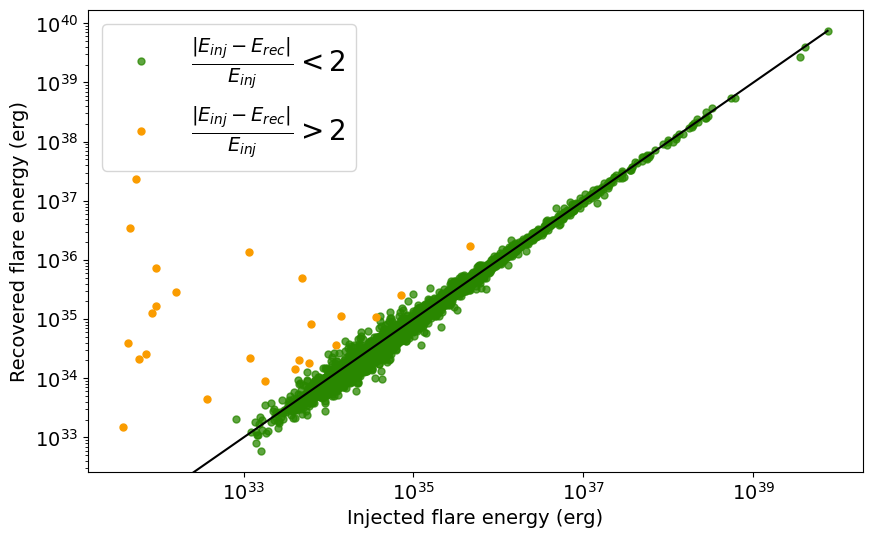

In [49]:
f, ax = plt.subplots(figsize=(10, 6))
ax.tick_params(axis='both', labelsize=14)

ginds = recovered_injflare_table["true_recovery"]
suspects = recovered_injflare_table["suspect"] | recovered_injflare_table["existing_flare"]
ax.plot(recovered_injflare_table['inj_flare_eng'][ginds], recovered_injflare_table["E"][ginds], 
        '.', alpha=0.75, color="#298700", ms=10 , label="$\\frac{|E_{inj}-E_{rec}|}{E_{inj}} < 2$")
ax.plot(recovered_injflare_table['inj_flare_eng'][~ginds & ~suspects], 
        recovered_injflare_table["E"][~ginds & ~suspects], 
        '.', ms=10, alpha=1, color="#fa9c00", label="$\\frac{|E_{inj}-E_{rec}|}{E_{inj}} > 2$")

minval,maxval = np.min(recovered_injflare_table['inj_flare_eng']), np.max(recovered_injflare_table['inj_flare_eng'])
ax.plot([minval,maxval],[minval,maxval], color='black')
ax.loglog()

ax.set_xlabel("Injected flare energy (erg)", fontsize=14)
ax.set_ylabel("Recovered flare energy (erg)", fontsize=14)
ax.legend(fontsize=20)

#f.savefig("../plots/recoveredVsInjectedEnergy.pdf")

plt.show()

**Plotting the injected vs recovered flare numbers**

In [46]:
all_injected_flares = None

for row in lc_info_table:
    if not all_injected_flares:
        all_injected_flares = Table.read(row['synth_flare_path'],format="ascii.ecsv")
    else:
        all_injected_flares = vstack((all_injected_flares,Table.read(row['synth_flare_path'],format="ascii.ecsv")))

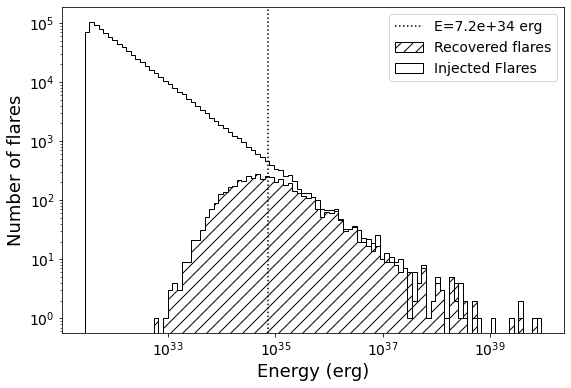

In [65]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.tick_params(axis='both', labelsize=14)
  
dbins = np.exp(np.linspace(72.4,92,100))
n, bins, patches = ax.hist([all_injected_flares['flare_eng'],
                            recovered_injflare_table[recovered_injflare_table["true_recovery"]]["E"]], 
                           dbins, histtype='step', stacked=False, label=["Injected Flares","Recovered flares"])

hatches = ['', '//']
for patch_set, hatch in zip(patches, hatches):
    plt.setp(patch_set, hatch=hatch, color="black")
    
ax.axvline(7.2e34, ls=":", c='k', label="E=7.2e+34 erg")
    
ax.legend(prop={'size': 14})
    
ax.set_xlabel("Energy (erg)", fontsize=18)
ax.set_ylabel("Number of flares", fontsize=18)

ax.loglog()

fig.savefig("../plots/recVsInjFlareHistogram.pdf")

plt.show()

In [66]:
recovered_injflare_table.write("../data_tables/recovered_injected_flares_longcad.ecsv",format="ascii.ecsv", overwrite=True)